C:\Users\wsfm\AppData\Local\Temp\ipykernel_19168\2382639786.py:90: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  out["date_dt"] = pd.to_datetime(out["date"], errors="coerce")
C:\Users\wsfm\AppData\Local\Temp\ipykernel_19168\2382639786.py:90: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  out["date_dt"] = pd.to_datetime(out["date"], errors="coerce")
C:\Users\wsfm\AppData\Local\Temp\ipykernel_19168\2382639786.py:90: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  out["date_dt"] = pd.to_datetime(out["date"], errors="coerce")


Saved: C:\Users\wsfm\OneDrive - Loughborough University\_Personal_Backup\ground_based_solar_irradiance\v_results_3_output\Figure_4_5_merged_months.png and C:\Users\wsfm\OneDrive - Loughborough University\_Personal_Backup\ground_based_solar_irradiance\v_results_3_output\Figure_4_5_merged_months.svg

Chosen representative days per panel (INST / FIT / DAILY):
  - March 2017: INST=2017-03-25, FIT=—, DAILY=2017-03-25
  - March 2018: INST=2018-03-23, FIT=2018-03-23, DAILY=2018-03-23
  - April 2017: INST=2017-04-29, FIT=—, DAILY=2017-04-29
  - April 2018: INST=2018-04-20, FIT=2018-04-20, DAILY=2018-04-20
  - October 2017: INST=2017-11-10, FIT=—, DAILY=2017-11-10
  - October 2018: INST=2018-10-13, FIT=2018-10-13, DAILY=2018-10-13


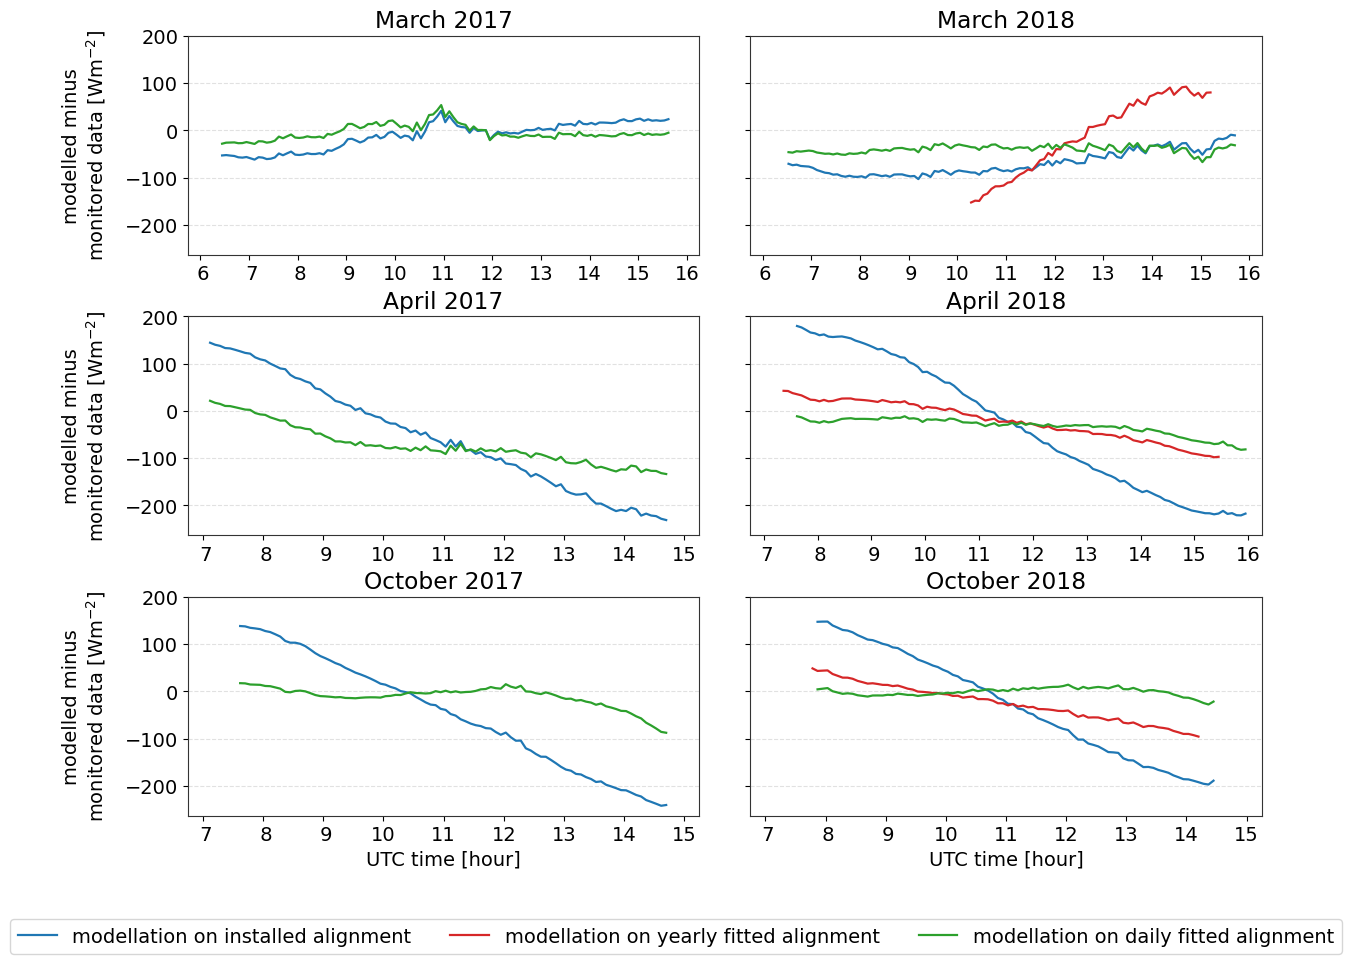

In [ ]:
# -*- coding: utf-8 -*-
"""
Figures 4.5.1–4.5.3 merged — 3×2 grid with three series per panel:
  • modelling on installed data  → from DAILY_CSV (hour_minute_installed / difference_installed)
  • modelling on fitted data     → from CSV_FIT   (hour_minute / difference)
  • modelling on daily fitted data → from DAILY_CSV (hour_minute_fitted / difference_fitted)

Panels by month/year:
  Row 1: March   2017 | March   2018
  Row 2: April   2017 | April   2018
  Row 3: October 2017 | October 2018

Notes:
  - We DO NOT use lazio1t30a180s0n3 / lazio1t28a211s0n3 for the “installed” series anymore.
  - Hour ticks are forced to 1-hour steps and formatted as 'H :00'.
  - Y-label only on the left column; bottom row x-label shows UTC time [HH:MM].
"""

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# --------------------------- Paths & filenames ---------------------------
BASE_DIR = r"C:/Users/wsfm/OneDrive - Loughborough University/_Personal_Backup/ground_based_solar_irradiance/"
INP_DIR  = os.path.join(BASE_DIR, "assets","alignment")
OUT_DIR  = os.path.join(BASE_DIR, "v_results_3_output")

# Fitted CSV (same structure as your 4.4.x files; now used only for the 'fitted' series)
CSV_FIT   = "lazio1t28a211s0n3.csv"      # fitted-orientation export

# Daily CSV (used for BOTH 'installed' and 'daily fitted' series)
DAILY_CSV = "_daily_alignment Lazio Pyranometer 1_analysis_251029.csv"

FONTSIZE = 14

# --------------------------- Helpers ---------------------------
def _must_exist(p: Path) -> Path:
    if not p.exists():
        raise FileNotFoundError(f"File not found: {p.resolve()}")
    return p

def _norm(s: str) -> str:
    return re.sub(r"\s+", " ", str(s).strip().lower())

def _resolve_col(df_cols, wanted: str, *aliases):
    """Case/space-insensitive column resolver."""
    norm_map = {_norm(c): c for c in df_cols}
    for w in (wanted, *aliases):
        k = _norm(w)
        if k in norm_map:
            return norm_map[k]
    return None

def _month_to_num(val):
    """Map 'month' values to 1..12 (accepts numbers or names like 'March', 'Mar')."""
    if pd.isna(val):
        return np.nan
    s = str(val).strip()
    # numeric?
    try:
        m = int(float(s))
        return m if 1 <= m <= 12 else np.nan
    except ValueError:
        pass
    # names
    full = ["January","February","March","April","May","June",
            "July","August","September","October","November","December"]
    full_map = {m.lower(): i for i, m in enumerate(full, 1)}
    abbr_map = {m[:3].lower(): i for m, i in full_map.items()}
    s2 = s.lower()
    if s2 in full_map: return full_map[s2]
    if s2[:3] in abbr_map: return abbr_map[s2[:3]]
    return np.nan

def _prep_series(df: pd.DataFrame, date_col: str, hm_col: str, diff_col: str, month_col: str | None) -> pd.DataFrame:
    """
    Standardize columns -> ['date_dt','year','month','hhmm','minutes_of_day','difference'].
    'month' column (if present) is preferred; otherwise derived from date.
    """
    use_cols = [c for c in [date_col, hm_col, diff_col, month_col] if c is not None]
    out = df[use_cols].copy()

    rename = {date_col: "date", hm_col: "hhmm", diff_col: "difference"}
    if month_col: rename[month_col] = "month_raw"
    out.rename(columns=rename, inplace=True)

    out["date_dt"] = pd.to_datetime(out["date"], errors="coerce")
    out["year"]    = out["date_dt"].dt.year

    if "month_raw" in out.columns:
        out["month"] = out["month_raw"].map(_month_to_num)
    else:
        out["month"] = out["date_dt"].dt.month

    out["hhmm"] = out["hhmm"].astype(str).str.slice(0, 5)
    hh = pd.to_datetime(out["hhmm"], format="%H:%M", errors="coerce")
    out["minutes_of_day"] = hh.dt.hour * 60 + hh.dt.minute

    out["difference"] = pd.to_numeric(out["difference"], errors="coerce")

    out = out.dropna(subset=["date_dt","year","month","minutes_of_day","difference"]).sort_values(
        ["date_dt","minutes_of_day"]
    )
    return out

def _best_day_by_count(df: pd.DataFrame, year: int, month: int) -> pd.Timestamp | None:
    """Pick the day with the highest number of samples in (year, month)."""
    sub = df[(df["year"] == year) & (df["month"] == month)]
    if sub.empty:
        return None
    counts = sub.groupby(sub["date_dt"].dt.date)["difference"].count().sort_values(ascending=False)
    return pd.Timestamp(counts.index[0])

def _slice_one_day(df: pd.DataFrame, day: pd.Timestamp) -> pd.DataFrame:
    sub = df[df["date_dt"] == day].copy()
    return sub.sort_values("minutes_of_day")

def hour_ticks_from_span(mins_min: int, mins_max: int):
    """Hourly tick positions (minutes-of-day) & labels like '8 :00'."""
    if not np.isfinite(mins_min) or not np.isfinite(mins_max):
        return [], []
    h_start = int(np.floor(mins_min / 60.0))
    h_end   = int(np.ceil (mins_max / 60.0))
    if h_end < h_start: h_end = h_start
    pos = [h * 60 for h in range(h_start, h_end + 1)]
    lab = [f"{h:>2d}" for h in range(h_start, h_end + 1)]
    return pos, lab

# --------------------------- Load data ---------------------------
INP = Path(INP_DIR); OUT = Path(OUT_DIR); OUT.mkdir(parents=True, exist_ok=True)

fitted_path = _must_exist(INP / CSV_FIT)
daily_path  = _must_exist(INP / DAILY_CSV)

fitted_raw  = pd.read_csv(fitted_path, dtype=str)
daily_raw   = pd.read_csv(daily_path,  dtype=str)

# Resolve columns for FITTED (from lazio1t28a211s0n3.csv)
c_date_f = _resolve_col(fitted_raw.columns, "date")
c_hm_f   = _resolve_col(fitted_raw.columns, "hour_minute")
c_dif_f  = _resolve_col(fitted_raw.columns, "difference")
c_mon_f  = _resolve_col(fitted_raw.columns, "month")   # you added this

if any(c is None for c in [c_date_f, c_hm_f, c_dif_f]):
    raise KeyError(f"Fitted CSV missing one of required columns: date/hour_minute/difference. "
                   f"Available: {list(fitted_raw.columns)}")

# Resolve columns for DAILY (two series: INSTALLED & DAILY-FITTED)
# Installed from daily file
c_date_di = _resolve_col(daily_raw.columns, "date", "date_fitted", "day")
c_hm_di   = _resolve_col(daily_raw.columns, "hour_minute_installed")
c_dif_di  = _resolve_col(daily_raw.columns, "difference_installed")
c_mon_di  = _resolve_col(daily_raw.columns, "month")

# Daily-fitted from daily file
c_date_dd = c_date_di  # same date column
c_hm_dd   = _resolve_col(daily_raw.columns, "hour_minute_fitted", "hour_minute")
c_dif_dd  = _resolve_col(daily_raw.columns, "difference_fitted",  "difference")
c_mon_dd  = c_mon_di

for what, col in [
    ("daily-installed: date", c_date_di), ("daily-installed: hour_minute_installed", c_hm_di),
    ("daily-installed: difference_installed", c_dif_di),
    ("daily-fitted: date", c_date_dd), ("daily-fitted: hour_minute_fitted", c_hm_dd),
    ("daily-fitted: difference_fitted", c_dif_dd),
]:
    if col is None:
        raise KeyError(f"Missing column for {what}. Daily columns: {list(daily_raw.columns)}")

# Prepare tidy frames
fitted_df     = _prep_series(fitted_raw, c_date_f, c_hm_f, c_dif_f, c_mon_f)
daily_inst_df = _prep_series(daily_raw, c_date_di, c_hm_di, c_dif_di, c_mon_di)
daily_fit_df  = _prep_series(daily_raw, c_date_dd, c_hm_dd, c_dif_dd, c_mon_dd)

# --------------------------- Month grid (3×2) ---------------------------
# Left column = 2017, Right column = 2018
MONTHS_GRID = [
    ("March",   3, 2017, 2018),
    ("April",   4, 2017, 2018),
    ("October",10, 2017, 2018),
]

# --------------------------- Plotting ---------------------------
plt.rcParams.update({
    "axes.edgecolor": "#333",
    "axes.linewidth": 0.8,
    "grid.color": "#bdbdbd",
    "grid.linestyle": "--",
    "grid.alpha": 0.45,
    "axes.grid": True,
    "font.size": FONTSIZE,
})

fig, axes = plt.subplots(3, 2, figsize=(12.2, 9.4), sharex=False, sharey=True)

COL_INST  = "#1f77b4"  # installed (from daily)
COL_FIT   = "#d62728"  # fitted   (from lazio1t28...)
COL_DAILY = "#2ca02c"  # daily fitted (from daily)

LAB_INST  = "modelling on installed alignment"
LAB_FIT   = "modelling on yearly fitted alignment"
LAB_DAILY = "modelling on daily fitted alignment"

# Legend proxies
proxy_inst,  = plt.plot([], [], color=COL_INST,  linewidth=1.6)
proxy_fit,   = plt.plot([], [], color=COL_FIT,   linewidth=1.6)
proxy_daily, = plt.plot([], [], color=COL_DAILY, linewidth=1.6)

chosen_days_log = []

for r, (mname, month, y_left, y_right) in enumerate(MONTHS_GRID):
    for c, year in enumerate([y_left, y_right]):
        ax = axes[r, c]

        # Choose one best day per SERIES (max samples)
        d_inst  = _best_day_by_count(daily_inst_df, year, month)  # installed from daily file
        d_fit   = _best_day_by_count(fitted_df,     year, month)  # fitted from lazio1t28...
        d_daily = _best_day_by_count(daily_fit_df,  year, month)  # daily-fitted from daily file

        chosen_days_log.append(
            f"{mname} {year}: INST={d_inst.date() if d_inst else '—'}, "
            f"FIT={d_fit.date() if d_fit else '—'}, "
            f"DAILY={d_daily.date() if d_daily else '—'}"
        )

        # Plot each series if present
        if d_inst is not None:
            sub = _slice_one_day(daily_inst_df, d_inst)
            if not sub.empty:
                ax.plot(sub["minutes_of_day"], sub["difference"], color=COL_INST, linewidth=1.6)

        if d_fit is not None:
            sub = _slice_one_day(fitted_df, d_fit)
            if not sub.empty:
                ax.plot(sub["minutes_of_day"], sub["difference"], color=COL_FIT,  linewidth=1.6)

        if d_daily is not None:
            sub = _slice_one_day(daily_fit_df, d_daily)
            if not sub.empty:
                ax.plot(sub["minutes_of_day"], sub["difference"], color=COL_DAILY, linewidth=1.6)

        # Hourly ticks from the union of available series for this panel
        mins_all = pd.concat([
            daily_inst_df.loc[daily_inst_df["date_dt"] == (d_inst  or pd.NaT),  "minutes_of_day"],
            fitted_df    .loc[fitted_df    ["date_dt"] == (d_fit   or pd.NaT),  "minutes_of_day"],
            daily_fit_df .loc[daily_fit_df ["date_dt"] == (d_daily or pd.NaT),  "minutes_of_day"],
        ], axis=0).dropna()

        if not mins_all.empty:
            xmin, xmax = int(mins_all.min()), int(mins_all.max())
            ticks, labs = hour_ticks_from_span(xmin, xmax)
            if ticks:
                ax.set_xticks(ticks)
                ax.set_xticklabels(labs)
                ax.set_xlim(ticks[0] - 15, ticks[-1] + 15)

        # Titles & labels
        ax.set_title(f"{mname} {year}")

        if c == 0:
            ax.set_ylabel("modelled minus\nmonitored data [Wm$^{-2}$]",
                          fontsize=FONTSIZE, labelpad=12)
        else:
            ax.set_ylabel("")
        ax.set_xlabel("UTC time [hour]" if r == 2 else "")
        ax.grid(True, axis="y"); ax.grid(False, axis="x")

# Legend close under the panels
fig.legend([proxy_inst, proxy_fit, proxy_daily],
           [LAB_INST, LAB_FIT, LAB_DAILY],
           loc="upper center", bbox_to_anchor=(0.5, 0.02),
           ncol=3, frameon=True, fontsize=FONTSIZE)

fig.subplots_adjust(wspace=0.10, hspace=0.28, bottom=0.12, left=0.10, right=0.98, top=0.95)

# Save
OUT.mkdir(parents=True, exist_ok=True)
png = OUT / "Figure_4_5_merged_months.png"
svg = OUT / "Figure_4_5_merged_months.svg"
plt.savefig(png, dpi=300)
plt.savefig(svg)
print(f"Saved: {png} and {svg}")

# Print the selected days for traceability
print("\nChosen representative days per panel (INST / FIT / DAILY):")
for line in chosen_days_log:
    print("  -", line)

C:\Users\wsfm\AppData\Local\Temp\ipykernel_19168\2245715958.py:87: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  return df.loc[pd.to_datetime(df[date_col], errors="coerce") == target].copy()
C:\Users\wsfm\AppData\Local\Temp\ipykernel_19168\2245715958.py:87: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  return df.loc[pd.to_datetime(df[date_col], errors="coerce") == target].copy()


Saved: C:\Users\wsfm\OneDrive - Loughborough University\_Personal_Backup\ground_based_solar_irradiance\v_results_3_output\Figure_4_5_2_variant.png and C:\Users\wsfm\OneDrive - Loughborough University\_Personal_Backup\ground_based_solar_irradiance\v_results_3_output\Figure_4_5_2_variant.svg


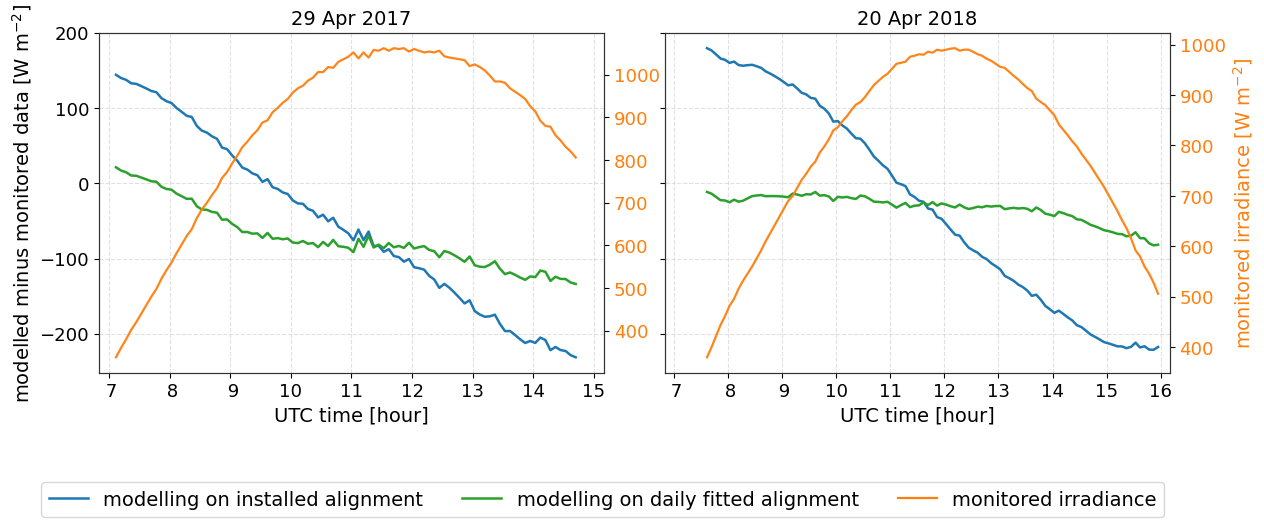

In [7]:
# -*- coding: utf-8 -*-
"""
Figure 4.5.2 (variant)
Two subplots in one row:
  • Left : 25/03/2017
  • Right: 23/03/2018

Data source (single file):
  _daily_alignment Lazio Pyranometer 1_analysis_251029.csv

Primary y-axis (left):
  • modelled minus monitored data [W m^-2]
  • series shown: installed alignment (difference_installed) and daily fitted alignment (difference_fitted)
  • x for installed : hour_minute_installed
  • x for daily-fit : hour_minute_fitted

Secondary y-axis (right, orange):
  • monitored irradiance from 'Pyranometer Cab 1 Irradiance [W/sqm]' (if non-null rows exist)

This version uses a single, figure-level legend centered under the two subplots and
drives legend, titles, axis labels, and tick labels from FONTSIZE.
"""

import os
import re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Requested dates
DATE_LEFT  = pd.Timestamp("2017-03-25")
DATE_RIGHT = pd.Timestamp("2018-03-23")

DATE_LEFT  = pd.Timestamp("2017-04-29")
DATE_RIGHT = pd.Timestamp("2018-04-20")

# --------------------------- Global font control ---------------------------
FONTSIZE = 14  # <--- change this and titles/labels/legend/ticks will follow

# --------------------------- Paths ---------------------------
BASE_DIR = r"C:/Users/wsfm/OneDrive - Loughborough University/_Personal_Backup/ground_based_solar_irradiance/"
INP_DIR  = os.path.join(BASE_DIR, "assets", "alignment")
OUT_DIR  = os.path.join(BASE_DIR, "v_results_3_output")
DAILY_CSV = "_daily_alignment Lazio Pyranometer 1_analysis_251029.csv"

# --------------------------- Helpers ---------------------------
def _must_exist(p: Path) -> Path:
    if not p.exists():
        raise FileNotFoundError(f"File not found: {p.resolve()}")
    return p

def _norm(s: str) -> str:
    return re.sub(r"\s+", " ", str(s).strip().lower())

def _resolve_col(df_cols, *candidates):
    """Return the first column in df_cols that matches any candidate (case/space-insensitive)."""
    norm_map = {_norm(c): c for c in df_cols}
    for cand in candidates:
        key = _norm(cand)
        if key in norm_map: return norm_map[key]
    return None

def _to_minutes(hhmm_series: pd.Series) -> pd.Series:
    hhmm = hhmm_series.astype(str).str.slice(0, 5)  # 'HH:MM'
    hh = pd.to_datetime(hhmm, format="%H:%M", errors="coerce")
    return hh.dt.hour * 60 + hh.dt.minute, hhmm
def _clean_numeric(s: pd.Series) -> pd.Series:
    # ' 1 234,5 ' → 1234.5
    return pd.to_numeric(
        s.astype(str)
         .str.replace("\u00A0","", regex=False).str.replace(" ", "", regex=False)
         .str.replace(",", ".", regex=False),
        errors="coerce"
    )

def _hour_ticks(mins_min: int, mins_max: int):
    if not np.isfinite(mins_min) or not np.isfinite(mins_max): return [], []
    h0 = int(np.floor(mins_min/60))
    h1 = int(np.ceil (mins_max/60))
    if h1 < h0: h1 = h0
    pos = [h*60 for h in range(h0, h1+1)]
    lab = [f"{h:>2d}" for h in range(h0, h1+1)]
    return pos, lab

def _slice_date(df: pd.DataFrame, date_col: str, target: pd.Timestamp) -> pd.DataFrame:
    return df.loc[pd.to_datetime(df[date_col], errors="coerce") == target].copy()

# --------------------------- Load ---------------------------
INP = Path(INP_DIR); OUT = Path(OUT_DIR); OUT.mkdir(parents=True, exist_ok=True)
daily_path = _must_exist(INP / DAILY_CSV)

raw = pd.read_csv(daily_path, dtype=str)

# Resolve columns in the daily file
col_date = _resolve_col(raw.columns, "date", "date_fitted", "day")
col_hm_inst = _resolve_col(raw.columns, "hour_minute_installed", "hour minute installed", "hour_minute_installation")
col_dif_inst = _resolve_col(raw.columns, "difference_installed")
col_hm_fit  = _resolve_col(raw.columns, "hour_minute_fitted", "hour minute fitted", "hour_minute")
col_dif_fit = _resolve_col(raw.columns, "difference_fitted", "difference")
col_irr     = _resolve_col(
    raw.columns,
    "Pyranometer Cab 1 Irradiance [W/sqm]",
    "Pyranometer Cab 1 Irradiance [W/m2]",
    "Piranometer Cab 1 Irradiance [W/sqm]",
    "Piranometer Cab 1 Irradiance [W/m2]",
    "Measured",
    "monitored irradiance [W/m2]"
)

for need, col in [
    ("date", col_date),
    ("hour_minute_installed", col_hm_inst),
    ("difference_installed", col_dif_inst),
    ("hour_minute_fitted", col_hm_fit),
    ("difference_fitted", col_dif_fit),
    ("irradiance", col_irr),
]:
    if col is None:
        raise KeyError(f"Missing column for {need}. Available columns: {list(raw.columns)}")


# Prepare per-date tables
def make_panel(df_raw: pd.DataFrame, date_val: pd.Timestamp):
    df = _slice_date(df_raw, col_date, date_val)
    if df.empty:
        print(f"[WARN] No rows found for {date_val.date()} in {daily_path.name}")
        return dict(inst=pd.DataFrame(), dfit=pd.DataFrame(), irr=pd.DataFrame())

    # Installed
    mins_i, hhmm_i = _to_minutes(df[col_hm_inst])
    y_i = _clean_numeric(df[col_dif_inst])
    inst = pd.DataFrame({"minutes": mins_i, "hhmm": hhmm_i, "value": y_i}).dropna().sort_values("minutes")

    # Daily-fitted
    mins_f, hhmm_f = _to_minutes(df[col_hm_fit])
    y_f = _clean_numeric(df[col_dif_fit])
    dfit = pd.DataFrame({"minutes": mins_f, "hhmm": hhmm_f, "value": y_f}).dropna().sort_values("minutes")

    # Irradiance
    irr_val = _clean_numeric(df[col_irr])
    irr = pd.DataFrame({"minutes": mins_i, "irr": irr_val}).dropna().sort_values("minutes")
    if irr.empty:
        irr = pd.DataFrame({"minutes": mins_f, "irr": irr_val}).dropna().sort_values("minutes")

    return dict(inst=inst, dfit=dfit, irr=irr)

panel_L = make_panel(raw, DATE_LEFT)
panel_R = make_panel(raw, DATE_RIGHT)

# --------------------------- Plotting ---------------------------
plt.rcParams.update({
    "axes.edgecolor": "#333",
    "axes.linewidth": 0.8,
    "grid.color": "#bdbdbd",
    "grid.linestyle": "--",
    "grid.alpha": 0.45,
    "axes.grid": True,
    "font.size": FONTSIZE,  # base font size (affects legend too)
})

fig, axes = plt.subplots(1, 2, figsize=(12.6, 5.0), sharex=False, sharey=True)
titles = [DATE_LEFT.strftime("%d %b %Y"), DATE_RIGHT.strftime("%d %b %Y")]

# Colors
COL_INST  = "#1f77b4"  # installed difference
COL_DFIT  = "#2ca02c"  # daily-fitted difference
COL_IRR   = "#ff7f0e"  # irradiance
LW_MAIN   = 1.8
LW_IRR    = 1.6

# ----- Proxy artists for one figure-level legend -----
proxy_inst,  = plt.plot([], [], color=COL_INST, linewidth=LW_MAIN)
proxy_dfit,  = plt.plot([], [], color=COL_DFIT, linewidth=LW_MAIN)
proxy_irr,   = plt.plot([], [], color=COL_IRR,  linewidth=LW_IRR)

for j, (ax, panel, ttl) in enumerate(zip(axes, [panel_L, panel_R], titles)):
    inst = panel["inst"]; dfit = panel["dfit"]; irr = panel["irr"]

    # Primary axis: installed & daily-fitted
    if not inst.empty:
        ax.plot(inst["minutes"], inst["value"], color=COL_INST, linewidth=LW_MAIN)
    if not dfit.empty:
        ax.plot(dfit["minutes"], dfit["value"], color=COL_DFIT, linewidth=LW_MAIN)

    # Secondary axis: irradiance (only if non-null rows exist)
    ax2 = None
    if not irr.empty:
        ax2 = ax.twinx()
        ax2.grid(False)
        ax2.plot(irr["minutes"], irr["irr"], color=COL_IRR, linewidth=LW_IRR, alpha=0.95)
        if j == 1:  # label only on the RIGHT subplot
            ax2.set_ylabel("monitored irradiance [W m$^{-2}$]", color=COL_IRR, fontsize=FONTSIZE)

        # Match tick label size on secondary y
        ax2.tick_params(axis="y", labelcolor=COL_IRR, labelsize=max(FONTSIZE-1, 8))

    # X ticks/limits from union of all series on this panel
    mins_union = []
    if not inst.empty: mins_union.append(inst["minutes"])
    if not dfit.empty: mins_union.append(dfit["minutes"])
    if not irr.empty:  mins_union.append(irr["minutes"])
    if mins_union:
        mu = pd.concat(mins_union).dropna()
        xmin, xmax = int(mu.min()), int(mu.max())
        ticks, labs = _hour_ticks(xmin, xmax)
        if ticks:
            ax.set_xticks(ticks); ax.set_xticklabels(labs, fontsize=max(FONTSIZE-1, 8))
            ax.set_xlim(ticks[0]-10, ticks[-1]+10)

    # Titles & labels with FONTSIZE
    ax.set_title(ttl, fontsize=FONTSIZE)
    if j == 0:
        ax.set_ylabel("modelled minus monitored data [W m$^{-2}$]", fontsize=FONTSIZE)
    ax.set_xlabel("UTC time [hour]", fontsize=FONTSIZE)

    # Match tick label size on primary axes
    ax.tick_params(axis="both", labelsize=max(FONTSIZE-1, 8))

# ---- Single, figure-level legend centered at the bottom ----
fig.legend(
    [proxy_inst, proxy_dfit, proxy_irr],
    ["modelling on installed alignment",
     "modelling on daily fitted alignment",
     "monitored irradiance"],
    loc="upper center", bbox_to_anchor=(0.5, 0.02),
    ncol=3, frameon=True, fontsize=FONTSIZE
)

# Layout and save
fig.subplots_adjust(wspace=0.12, bottom=0.22, left=0.10, right=0.95, top=0.90)

OUT.mkdir(parents=True, exist_ok=True)
png = OUT / "Figure_4_5_2_variant.png"
svg = OUT / "Figure_4_5_2_variant.svg"
fig.savefig(png, dpi=300)
fig.savefig(svg)
print(f"Saved: {png} and {svg}")